In [43]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
import torch
#from torch import nn
#from torch.utils.data import DataLoader
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import train, test, plot_confusion_matrix
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, LSTM, Dropout, Dense
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# import flatten
from tensorflow.keras.layers import Flatten, Softmax
from tensorflow.keras.models import load_model
from keras import models, layers
from keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import StandardScaler


# Data Loader

In [51]:
# mac
sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
#sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
#label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
#sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50


In [52]:
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [53]:
in_channels = 9
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

in_channels:  9
data.shape:  (25617, 50, 9)


In [54]:
label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
data = data.reshape(data.shape[0], 50, 9)
# normalize the data
# Initialize a new scaling object for normalizing input data
# Z-score normalization


# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)



device = (
     "cuda"
     if torch.cuda.is_available()
     else "cpu"
 )
#device = "cpu"
print(f"Using {device} device")

B_size:  25020
A_size:  597
data:  [-1.09000000e-01 -3.40000000e-02  1.01200000e+00  4.01070600e-01
  0.00000000e+00  0.00000000e+00  1.77662817e+02 -6.10773228e+00
 -2.71238317e+01]
(240, 50, 9)
Using cpu device


# Hyperparameters

In [55]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# ConvLSTM

In [ ]:
# Define the Conv1D-3 Block as a function to avoid repetition
def conv1d_3_block(filters, kernel_size, pool_size, pool_strides):
    block = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size,padding='same'),
        Conv1D(filters=filters, kernel_size=kernel_size, padding='same'),
        Conv1D(filters=filters, kernel_size=kernel_size, padding='same'),
        ReLU(),
        BatchNormalization(),
        MaxPooling1D(pool_size=pool_size, strides=pool_strides)
    ])
    return block

In [ ]:
ConvLSTM = Sequential([
    # The Conv1D-3 Block is repeated three times
    conv1d_3_block(filters=64, kernel_size=3, pool_size=2, pool_strides=2),
    conv1d_3_block(filters=64, kernel_size=3, pool_size=2, pool_strides=2),
    conv1d_3_block(filters=64, kernel_size=3, pool_size=2, pool_strides=2),
    # Followed by two LSTM layers
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    
    # Flatten the output to feed into the Dense layers
    Flatten(),
    # Two Dense layers with ReLU activation
    Dense(32, activation='relu'),
    Dense(2, activation='softmax'),
])

In [ ]:
'''
ConvLSTM = Sequential([
    # Conv1
    Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(50, 9)),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    # Conv2
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    # Conv3
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    # LSTM layers
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    # flatten
    Flatten(),
    # Fully connected layer
    Dense(32),
    # relu
    ReLU(),
    # softmax
    Dense(2, activation='softmax')
])
'''

In [ ]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


ConvLSTM.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = ConvLSTM.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

In [ ]:
# summary of the model
ConvLSTM.summary()

In [ ]:
# Evaluate the model

print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = ConvLSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

In [ ]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(ConvLSTM.predict(X_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)


# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

In [ ]:
ConvLSTM.save('ConvLSTM_baseline.h5')

In [ ]:
# load the model

ConvLSTM = load_model('ConvLSTM_baseline.h5')
# Get the model's predictions
predictions = np.argmax(ConvLSTM.predict(X_test), axis=-1)
# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

# Convert the model to TF lite

In [ ]:
# Convert the model to TFLite without quantization
# tried to larger set of Tensorflow ops
converter = tf.lite.TFLiteConverter.from_keras_model(ConvLSTM)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
ConvLSTM_tflite_model = converter.convert()
# save the model
# Save the model to disk
open("ConvLSTM_tflite.tflite", "wb").write(ConvLSTM_tflite_model)
#ConvLSTM_tflite_model.save('ConvLSTM_tflite.tflite')
# Show the model size for the non-quantized HDF5 model
ConvLSTM_h5_in_kb = os.path.getsize('ConvLSTM_baseline.h5') / 1024
print("HDF5 Model size without quantization: %d KB" % ConvLSTM_h5_in_kb)

# Show the model size for the non-quantized TFLite model
ConvLSTM_tflite_in_kb = os.path.getsize('ConvLSTM_tflite.tflite') / 1024
print("TFLite Model size without quantization: %d KB" % ConvLSTM_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in file size by a factor of %f" % (ConvLSTM_h5_in_kb / ConvLSTM_tflite_in_kb))

# TF lite dynamic range Quantization

In [ ]:


ConvLSTM = load_model('ConvLSTM_baseline.h5')

# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(ConvLSTM)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
dynR_quant_tflite_ConvLSTM = converter.convert()

# save the quantized model
with open('dynR_quant_tflite_ConvLSTM.tflite', 'wb') as f:
    f.write(dynR_quant_tflite_ConvLSTM)




In [ ]:
interpreter = tf.lite.Interpreter(model_content=dynR_quant_tflite_ConvLSTM)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
# Show the model size for the dynamic ranged quantized TFLite model
tflite_quant_in_kb = os.path.getsize('dynR_quant_tflite_ConvLSTM.tflite') / 1024
print("TFLite Model size with dynamic quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % ConvLSTM_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (ConvLSTM_tflite_in_kb / tflite_quant_in_kb))

# int8 Quantization

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(ConvLSTM)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8 = converter.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
# Save the quantized model
with open('tflite_model_quant_int8_ConvLSTM.tflite', 'wb') as f:
    f.write(tflite_model_quant_int8)


In [ ]:
# Show the model size for the 8-bit quantized TFLite model
tflite_quant_in_kb = os.path.getsize('tflite_model_quant_int8_ConvLSTM.tflite') / 1024
print("TFLite Model size with 8-bit quantization: %d KB" % tflite_quant_in_kb)

print("TFLite Model size without quantization: %d KB" % ConvLSTM_tflite_in_kb)

# Determine the reduction in model size
print("\nReduction in model size by a factor of %f" % (ConvLSTM_tflite_in_kb / tflite_quant_in_kb))

# Evaluate the quantized models

In [ ]:
# test the quantized model
X_test_int8 = X_test.astype('uint8')
y_test_int8 = y_test.astype('uint8')
#print(y_test_int8)
# now y_test_int8 is one-hot encoded. convert y_test_int8 back
#y_test_int8 = np.argmax(y_test_int8, axis=-1)
print(X_test_int8.shape)
print(y_test_int8.shape)
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= tflite_model_quant_int8)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

# convert the predictions from one hot back to int

print(predictions.shape)
y_test_int8 = np.argmax(y_test_int8, axis=-1)
#print(np.argmax(y_test_int8, axis=-1))
print(y_test_int8.shape)
accuracy = (predictions == y_test_int8).mean()
print('accuracy: ', accuracy)
# compute the confusion matrix
cm = confusion_matrix(y_test_int8, predictions)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')



In [ ]:
# test the quantized model
X_test_int8 = X_test.astype('float32')
y_test_int8 = y_test.astype('float32')
#print(y_test_int8)
# now y_test_int8 is one-hot encoded. convert y_test_int8 back
#y_test_int8 = np.argmax(y_test_int8, axis=-1)
print(X_test_int8.shape)
print(y_test_int8.shape)
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= dynR_quant_tflite_ConvLSTM)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

# convert the predictions from one hot back to int

print(predictions.shape)
y_test_int8 = np.argmax(y_test_int8, axis=-1)
#print(np.argmax(y_test_int8, axis=-1))
print(y_test_int8.shape)
accuracy = (predictions == y_test_int8).mean()
print('accuracy: ', accuracy)
# compute the confusion matrix
cm = confusion_matrix(y_test_int8, predictions)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')



# ResNet24

In [56]:
inputs = keras.Input(shape=(50, 9))
x = layers.Reshape((1, 50, 9))(inputs)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 3))(x)
x = layers.MaxPooling2D(pool_size=(1, 2))(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# ConvBlock
residual = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

# IdentityBlock
residual = x
x = layers.Conv2D(filters=16, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=16, kernel_size=(1, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(filters=64, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, residual])
x = layers.ReLU()(x)

x = layers.AveragePooling2D(pool_size=(1, 2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(2, activation='softmax')(x)

ResNet24 = keras.Model(inputs=inputs, outputs=outputs, name="ResNet24")

In [57]:
print(f"Model structure: \n")
ResNet24.build(input_shape=(None, 50, 9))
ResNet24.summary()

Model structure: 

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 50, 9)             0         ['input_2[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 1, 48, 64)            1792      ['reshape_1[0][0]']           
                                                                                                  
 conv2d_28 (Conv2D)          (None, 1, 46, 64)            12352     ['conv2d_27[0][0]']           
                                                                        

In [58]:
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


ResNet24.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
lrs = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, verbose=1)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = ResNet24.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es, lrs],
          class_weight=class_weight) 

y_train.shape:  (16394, 2)
y_val.shape:  (4099, 2)
X_train.shape:  (16394, 50, 9)
y_train.shape:  (16394, 2)
Epoch 1/50
257/257 [==============================] - 9s 25ms/step - loss: 1.4842 - accuracy: 0.8094 - val_loss: 0.4124 - val_accuracy: 0.8922 - lr: 5.0000e-04
Epoch 2/50
257/257 [==============================] - 7s 26ms/step - loss: 0.9538 - accuracy: 0.8587 - val_loss: 0.2678 - val_accuracy: 0.9314 - lr: 5.0000e-04
Epoch 3/50
257/257 [==============================] - 6s 23ms/step - loss: 0.8049 - accuracy: 0.8643 - val_loss: 0.3755 - val_accuracy: 0.8931 - lr: 5.0000e-04
Epoch 4/50
257/257 [==============================] - 6s 24ms/step - loss: 0.5980 - accuracy: 0.8915 - val_loss: 0.2925 - val_accuracy: 0.9097 - lr: 5.0000e-04
Epoch 5/50
257/257 [==============================] - 6s 24ms/step - loss: 0.5557 - accuracy: 0.8840 - val_loss: 0.3996 - val_accuracy: 0.8890 - lr: 5.0000e-04
Epoch 6/50
257/257 [==============================] - 6s 24ms/step - loss: 0.5148 - accurac

In [59]:
# Evaluate the model
print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = ResNet24.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (240, 50, 9)
8/8 - 0s - loss: 0.2289 - accuracy: 0.9250 - 45ms/epoch - 6ms/step
Test loss: [0.22887654602527618, 0.925000011920929]


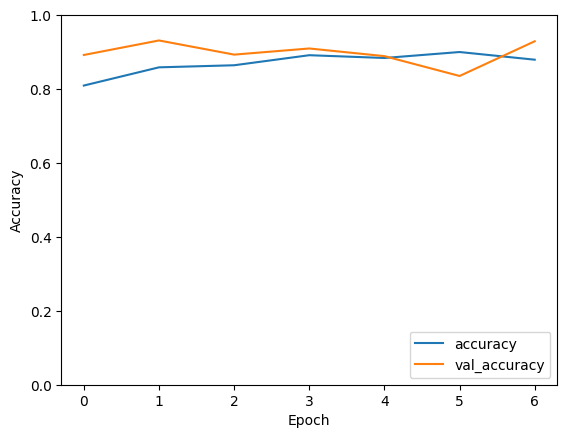

In [60]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

8/8 [==============================] - 0s 4ms/step
[[113   3]
 [ 15 109]]
Confusion matrix, without normalization
[[113   3]
 [ 15 109]]


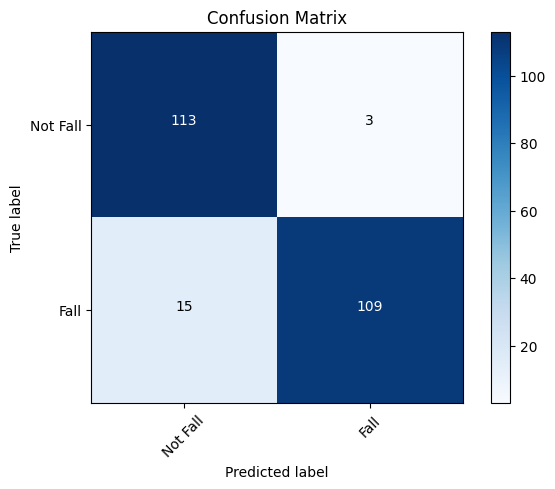

In [61]:
# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(ResNet24.predict(X_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')

In [62]:
ResNet24.save('ResNet24.keras')  # The file needs to end with the .keras extension

In [63]:
q_ResNet24 = tfmot.quantization.keras.quantize_model(ResNet24)
q_ResNet24.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

q_ResNet24.summary()

Model: "ResNet24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 9)]              0         []                            
                                                                                                  
 quantize_layer_1 (Quantize  (None, 50, 9)                3         ['input_2[0][0]']             
 Layer)                                                                                           
                                                                                                  
 quant_reshape_1 (QuantizeW  (None, 1, 50, 9)             1         ['quantize_layer_1[0][0]']    
 rapperV2)                                                                                        
                                                                                           

In [64]:
q_history = q_ResNet24.fit(X_train, y_train, 
            validation_data=(X_val, y_val), 
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=[es, lrs],
            class_weight=class_weight) 

Epoch 1/50
257/257 [==============================] - 13s 36ms/step - loss: 0.9425 - accuracy: 0.7927 - val_loss: 0.2858 - val_accuracy: 0.9158 - lr: 5.0000e-04
Epoch 2/50
257/257 [==============================] - 9s 37ms/step - loss: 0.7741 - accuracy: 0.8362 - val_loss: 0.2423 - val_accuracy: 0.9090 - lr: 5.0000e-04
Epoch 3/50
257/257 [==============================] - 10s 37ms/step - loss: 0.6831 - accuracy: 0.8695 - val_loss: 0.1702 - val_accuracy: 0.9305 - lr: 5.0000e-04
Epoch 4/50
257/257 [==============================] - 9s 36ms/step - loss: 0.6453 - accuracy: 0.8734 - val_loss: 0.5239 - val_accuracy: 0.8004 - lr: 5.0000e-04
Epoch 5/50
257/257 [==============================] - 9s 36ms/step - loss: 0.5651 - accuracy: 0.8836 - val_loss: 0.1480 - val_accuracy: 0.9444 - lr: 5.0000e-04
Epoch 6/50
257/257 [==============================] - 9s 35ms/step - loss: 0.5660 - accuracy: 0.8823 - val_loss: 0.4149 - val_accuracy: 0.8363 - lr: 5.0000e-04
Epoch 7/50
257/257 [==================

In [65]:
q_ResNet24.save('q_ResNet24.keras')  # The file needs to end with the .keras extension


In [66]:
'''
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(q_ResNet24)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant_int8 = converter.convert()
'''

"\ndef representative_data_gen():\n  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):\n    yield [input_value]\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(q_ResNet24)\nconverter.optimizations = [tf.lite.Optimize.DEFAULT]\nconverter.representative_dataset = representative_data_gen\nconverter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\nconverter._experimental_lower_tensor_list_ops = False\nconverter.inference_input_type = tf.int8\nconverter.inference_output_type = tf.int8\n\ntflite_model_quant_int8 = converter.convert()\n"

In [67]:
# convert the QAT model to a fully quantized model using TFLite

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train.astype('float32')).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(q_ResNet24)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_int8_qat = converter.convert()

KeyboardInterrupt: 

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8_qat)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
# Save the quantized model to disk
open("models/fmnist_qat_int8.tflite", "wb").write(tflite_model_quant_int8_qat)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


109104

In [ ]:
# test the quantized model
print(X_test[0][0])
print('####')
X_test_int8 = X_test.astype('uint8')
y_test_int8 = y_test.astype('uint8')
#print(y_test_int8)
# now y_test_int8 is one-hot encoded. convert y_test_int8 back
#y_test_int8 = np.argmax(y_test_int8, axis=-1)
print(X_test_int8[0])
print(y_test_int8.shape)
# Load the model into an interpreter
interpreter = tf.lite.Interpreter(model_content= tflite_model_quant_int8_qat)
# Allocate memory for the model's input Tensor(s)
interpreter.allocate_tensors()
# Get the model input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print("input: ", input_details)
print("output: ", output_details)
predictions = np.zeros(X_test.shape[0])
for i, test_data in enumerate(X_test_int8):
    test_data = np.expand_dims(test_data, axis=0)
    #print(test_data.shape)
    interpreter.set_tensor(input_details["index"], test_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    if i%100 == 0:
        # print("Evaluated on %d images." % test_image_index)
        print('Evaluated on ', i, '.')
    predictions[i] = output.argmax()

# convert the predictions from one hot back to int


[ 0.10717244 -0.11876063 -0.9641799  -0.57687505  1.35874835  0.82601957
 -0.25227563  0.24004562 -0.11913926]
####
[[  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1   0   0   0]
 [  0   0   0   0   1   1 

In [ ]:

print(predictions.shape)
y_test_int8 = np.argmax(y_test_int8, axis=-1)
#print(np.argmax(y_test_int8, axis=-1))
print(y_test_int8.shape)
accuracy = (predictions == y_test_int8).mean()
print('y_test_int8: ', y_test_int8)
print('predictions: ', predictions)
print('accuracy: ', accuracy)
# compute the confusion matrix
cm = confusion_matrix(y_test_int8, predictions)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')